# Generalization with OOP: The CBacktester Class

## Building the CBacktester Class from scratch: Instantiation

In [179]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
plt.style.use('seaborn')

In [225]:
class CBacktester():
    def __init__(self, symbol, window, start, end):
        self.symbol = symbol
        self.window = window
        self.start = start
        self.end = end
        self.results = None
        self.get_data()
        self.prepare_data()
        
    def __repr__(self):
        return "CBacktester: symbol = {}, window = {}, start = {}, end = {}".\
        format(self.symbol, self.window, self.start, self.end)
        
    def get_data(self):
        raw = pd.read_csv("intraday.csv", parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.loc[:,["price"]].shift(1))
        self.data = raw
        return raw
    
    def prepare_data(self):
        data = self.data.copy()
        #data["window"] = data["returns"].rolling(self.window).mean()
        self.data = data
    
    def set_parameters(self, window = None):
        if window is not None:
            self.window = window
            #self.data['window'] = self.data['price'].rolling(self.window).mean()
            
    def test_strategy(self):
        data = self.data.copy().dropna()
        data['position'] = -np.sign(data['returns'].rolling(self.window).mean())
        data['strategy'] = data['position'].shift(1) * data['returns']
        data.dropna(inplace=True)
        data['creturns'] = data['returns'].cumsum().apply(np.exp)
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp)
        self.results = data
        
        perf = data['cstrategy'].iloc[-1]
        outperf = perf - data['creturns'].iloc[-1]
        
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        if self.results is None:
            print("Run test_strategy() before running plot_results()")
        else:
            self.results.loc[:,['creturns','cstrategy']]\
            .plot(title = "{} | {}-Bar Contrarian Window".format(self.symbol,\
            self.window),figsize=(12,8))
            
    def optimize_parameters(self, window_range):
        combinations = range(*window_range)
        
        results = []
        i = 0
        for comb in combinations:
            #Track iterations
            i+=1
            clear_output(wait=True)
            display('Iteration {} of {}. Testing window = {}'.\
            format(i, str(len(combinations)), comb))
            
            #test strategy
            self.set_parameters(comb)
            results.append(self.test_strategy()[0])
        
        #clearing output again so that there is no confusion 
        #about if the last iteration was the most optimal combination
        clear_output(wait=True)
        
        best_perf = np.max(results)
        opt = combinations[np.argmax(results)]
        
        self.set_parameters(opt)
        self.test_strategy()
        self.plot_results()
        
        many_results = pd.DataFrame(data = combinations, columns = ["window"])
        many_results['performance'] = results
        self.results_overview = many_results
        
        return opt, best_perf        

In [226]:
insample = CBacktester("price", 3, "2018-01-01", "2019-12-30")
insample

CBacktester: symbol = price, window = 3, start = 2018-01-01, end = 2019-12-30

In [227]:
insample.get_data()
insample.prepare_data()
insample.set_parameters(3)

### checkpoint: instantation, get_data, set_parameters work

In [228]:
insample.prepare_data()

In [229]:
insample.test_strategy()

(1.101019, 0.171881)

In [230]:
insample.results

,price,returns,position,strategy,creturns,cstrategy
time,,,,,,
2018-01-02 22:00:00+00:00,1.204690,-0.000921,1.0,0.000921,0.999079,1.000921
2018-01-03 04:00:00+00:00,1.203825,-0.000718,1.0,-0.000718,0.998362,1.000203
2018-01-03 10:00:00+00:00,1.202355,-0.001222,1.0,-0.001222,0.997143,0.998981
2018-01-03 16:00:00+00:00,1.201445,-0.000757,1.0,-0.000757,0.996388,0.998225
2018-01-03 22:00:00+00:00,1.201450,0.000004,1.0,0.000004,0.996392,0.998229
...,...,...,...,...,...,...
2019-12-29 22:00:00+00:00,1.119920,0.002092,-1.0,-0.002092,0.928778,1.100591
2019-12-30 04:00:00+00:00,1.119940,0.000018,-1.0,-0.000018,0.928794,1.100572
2019-12-30 10:00:00+00:00,1.120095,0.000138,-1.0,-0.000138,0.928923,1.100420


(44, 1.288223)

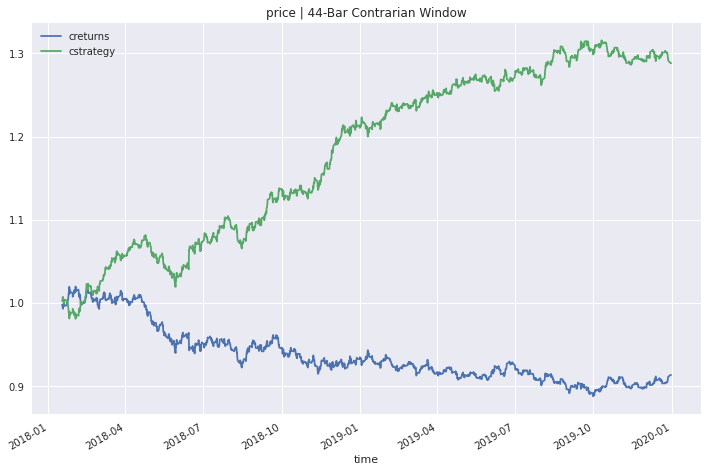

In [231]:
insample.optimize_parameters((1,252,1))

__Backtesting & Forward Testing__

<AxesSubplot:xlabel='time'>

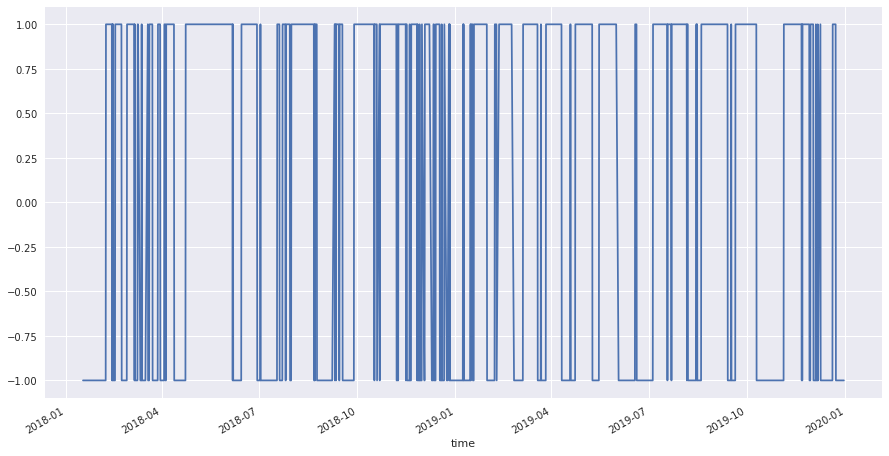

In [232]:
insample.results['position'].plot(figsize=(15,8))

__AUD/EUR__

## Method get_data()

## Setting new SMA Paramters

## Testing a Strategy

## Plotting the results

## Strategy Optimization

## Splitting get_data() and adding prepare_data() 

## String Representation & Docstrings